# Applying hyperopt to MLlib

## Set up Spark and install hyperopt

In [1]:
import findspark
from pyspark.sql import SparkSession

findspark.init()
spark = SparkSession \
    .builder \
    .appName("Python") \
    .master("local[*]") \
    .getOrCreate()

spark

## Imports

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, Tokenizer, CountVectorizer, IDF, NGram
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import time

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

## Read and show data

In [3]:
train_data = spark.read.option("delimiter",";").csv("./data/train.txt")
val_data = spark.read.option("delimiter",";").csv("./data/val.txt")

raw_data = train_data.union(val_data)

raw_data = raw_data.withColumnRenamed("_c0", "text")\
                   .withColumnRenamed("_c1", "label_text")

raw_data.cache()
raw_data.count()

raw_data.show()

+--------------------+----------+
|                text|label_text|
+--------------------+----------+
|i didnt feel humi...|   sadness|
|i can go from fee...|   sadness|
|im grabbing a min...|     anger|
|i am ever feeling...|      love|
|i am feeling grouchy|     anger|
|ive been feeling ...|   sadness|
|ive been taking o...|  surprise|
|i feel as confuse...|      fear|
|i have been with ...|       joy|
| i feel romantic too|      love|
|i feel like i hav...|   sadness|
|i do feel that ru...|       joy|
|i think it s the ...|     anger|
|i feel low energy...|   sadness|
|i have immense sy...|       joy|
|i do not feel rea...|       joy|
|i didnt really fe...|   sadness|
|i feel pretty pat...|   sadness|
|i started feeling...|   sadness|
|i now feel compro...|      fear|
+--------------------+----------+
only showing top 20 rows



## Some data checks

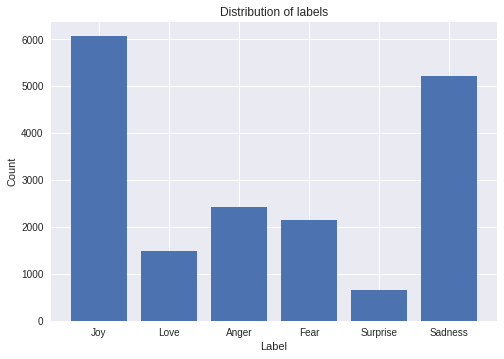

In [4]:
rows = raw_data.groupby("label_text").count().collect()
labels = [row['label_text'].capitalize() for row in rows]
count = [row['count'] for row in rows]

plt.bar(labels, count)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of labels")

plt.show()

## Evaluate Logistic regression model with hyperopt

In [14]:
# Create the MLlib pipeline
def create_pipeline():
    # A sub-pipeline for the feature extraction
    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    stop_words_remover = StopWordsRemover(inputCol="words", outputCol="clean_words")
    ngram = NGram(n=1, inputCol="clean_words", outputCol="ngrams")
    count_vectorizer = CountVectorizer(minDF=10, vocabSize=1000000, inputCol='ngrams', outputCol='counts')
    tf_idf = IDF(inputCol="counts", outputCol="features")
    label_indexer= StringIndexer(inputCol="label_text", outputCol="label")
    feature_pipeline = Pipeline(stages=[tokenizer, stop_words_remover, ngram, count_vectorizer, tf_idf, label_indexer])

    # The pipeline including the model
    lr = LogisticRegression(maxIter=1000, tol=1e-06, regParam=0.00, elasticNetParam=0.00)
    pipeline = Pipeline(stages=[feature_pipeline, lr])
    
    return pipeline, count_vectorizer, lr
    
# This is the objective function for HyperOpt
def objective(params): 
    global best_loss
    
    seed = params['seed']
    
    pipeline, count_vectorizer, lr = create_pipeline()

    # The grid has only one option
    paramGrid = ParamGridBuilder() \
    .addGrid(count_vectorizer.minDF, [int(params['minDF'])]) \
    .addGrid(count_vectorizer.vocabSize, [int(params['vocabSize'])]) \
    .addGrid(lr.regParam, [params['regParam']]) \
    .addGrid(lr.elasticNetParam, [params['elasticNetParam']]) \
    .build()
    
    # F1 is the default metric
    # 2*((precision*recall)/(precision+recall))
    # This is likely weighted macro
    evaluator = MulticlassClassificationEvaluator(metricName='f1')
    
    # Setup and perform the cross-validation
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=5,
                             seed=seed)  

    cvModel = crossval.fit(raw_data)
    f1Score = cvModel.avgMetrics[0]
    loss = 1.0 - f1Score
    
    if loss < best_loss:
        best_loss = loss
        pipeline.write().overwrite().save("./best_model")

    return {
        'loss': loss,
        'status': STATUS_OK,
        'eval_time': time.time()
        }

# Define the search space 
search_space = {
  'seed': hp.randint('seed', 1000000),
  'minDF': hp.uniform('minDF', 2, 15),
  'vocabSize': hp.loguniform('vocabSize', np.log(1000), np.log(1000000)),
  'regParam': hp.loguniform('regParam', -4.0, 0),
  'elasticNetParam': hp.uniform('elasticNetParam', 0.0, 1.0),
}

best_loss = 1.0

# Run HyperOpt
trials = Trials()
best = fmin(objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials)

100%|██████████| 50/50 [29:36<00:00, 35.53s/trial, best loss: 0.09557726239785147]


In [15]:
print(best)

{'elasticNetParam': 0.29943594885296565, 'minDF': 2.020574042621897, 'regParam': 0.018617929402275964, 'seed': 678637, 'vocabSize': 3461.762847776756}


In [17]:
1.0 - 0.09557726239785147

0.9044227376021485

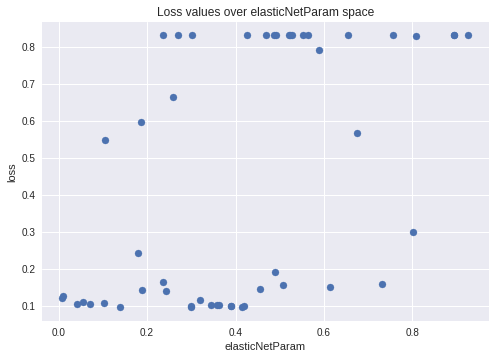

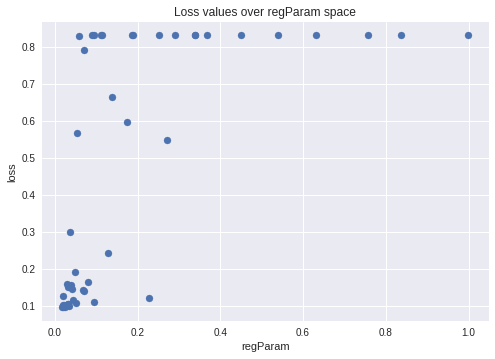

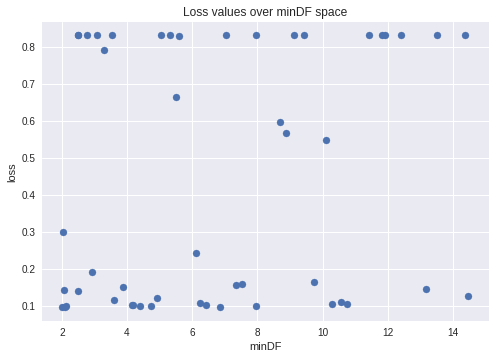

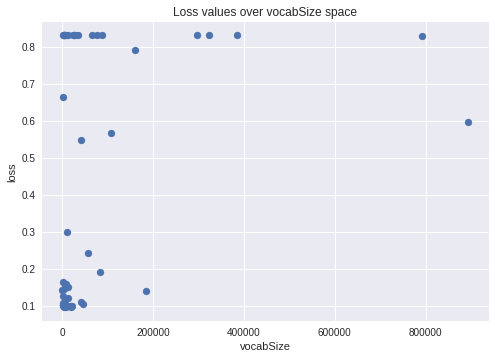

In [18]:
for param in ['elasticNetParam','regParam','minDF','vocabSize']:
    x = []
    y = []
    for trial in trials.trials:
        loss = trial['result']['loss']
        value = trial['misc']['vals'][param]
        
        x.append(value)
        y.append(loss)
        
    plt.scatter(x, y)
    plt.xlabel(param)
    plt.ylabel("loss")
    plt.title("Loss values over {} space".format(param))

    plt.show()